# **Brief explanation**

For this project, our goal is to solve an imputation problem: we will create a neural network architecture that learns how to recover missing portions of an image.

This is an important problem in magnetic resonance imaging (MRI), where patient scans are often limited to a few areas to avoid lengthy scanning times.

In particular, we are going to focus on images of human heads. We have managed to gain access to one hundred images of patient's heads but, unfortunately, these images have a significant portion of missing information. Your goal during the assessment is to design a neural network that can recover these missing portions.


---

<br>

We do not have access to the labels for the images we want to recover, so we will have to be a bit creative to obtain a workable dataset on which to train our neural network.

Fortunately for us, we have access to a generative model that has been trained to produce realistic-looking MRI images of patient's heads. Using this model, you will create an appropriate dataset to train your architecture. We have provided you with the basic setup code to start using this generative model in **Question 1** below.

The corrupted images that we want to recover are contained in the numpy file `test_set.npy` of this repository. The file contains 100 patient images with a size of 64x64 pixels.

The architecture that you design in this assessment should use the artificially-generated dataset in order to recover the missing information in the images contained in `test_set.npy`.


---

<br>

<br>

# **Question 1** 

Using the provided image-generation network, create a dataset of brain images that will later be used to train your chosen architecture.

Given that you will likely want to use this dataset multiple times during training, we recommend that you save the generated images to an appropriate folder in your GDrive.

Once you have generated your dataset, load and display ten of your generated images here.

We have also provided you with some corrupted images in the file `test_set.npy` of this repository. You should also load and display ten of these corrupted images here.

Below, we have provided template code, including some required downloads and installations, so that you can easily use the trained generative model. Sample generation in this model is done using the function `generate`, and is controlled by some input arguments. It is your job to figure out a sensible set of parameters that will produce images that are useful for the requirements of your task.

<br>

In [1]:
import os
import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# INSTRUCTIONS:
# Open in a BROWSER https://drive.google.com/file/d/1I8Ry7Z_QqnlARwOuDgN4NPCd-GcLw1OC/view?usp=drive_link
# Download the file cw1_files.zip
# Go to https://drive.google.com/ and log in with the account you will be using for this coursework
# In the folder 'My Drive' upload cw1_files.zip (DO NOT UNZIP THE FILE)
# Run the following:

!unzip /content/drive/MyDrive/cw1_files.zip -d ./
!chmod +x run.sh
!bash ./run.sh
sys.path.append('/content/ese-invldm')

Mounted at /content/drive
Archive:  /content/drive/MyDrive/cw1_files.zip
  inflating: ./files/config_training.yml  
  inflating: ./run.sh                
  inflating: ./ese-invldm/setup.py   
  inflating: ./files/default_config.yml  
  inflating: ./ese-invldm/ese_invldm/ese_invldm.py  
  inflating: ./ese-invldm/ese_invldm/__init__.py  
  inflating: ./files/autoencoder/autoencoder_ckpt_latest.pth  
  inflating: ./files/diffusion/diffusion_ckpt_latest.pth  
Cloning the repository from https://github.com/dpelacani/InverseLDM.git...
Cloning into 'InverseLDM'...
remote: Enumerating objects: 1331, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 1331 (delta 167), reused 182 (delta 100), pack-reused 1070 (from 1)
Receiving objects: 100% (1331/1331), 467.16 KiB | 4.41 MiB/s, done.
Resolving deltas: 100% (875/875), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.2 MB

## Generate train dataset

In this part, I used the provided image-generation network to create a dataset of brain images as the train dataset. And my job is to figure out a sensible set of parameters which will be passed into the function `generate`. Because the final task is recovering corrupted images from `test_set.npy`, so the train dataset I created here should be as close as possible to the images in `test_set.npy`. In addition, I suspect that the train dataset of the image generation model used here may contain the corrupted images or the uncorrupted version of corrupted images in `test_set.npy`. My reasons for choosing the parameters are as follows.

num_samples(3000):Since it is the training dataset, the data is generated as much as the computational and time costs permit. So I chose to generate 3000 samples as the dataset.

num_inference_steps(50):This task is an recovery mission of MRI image, it is critical to generate high quality images. So I selected 50 inferences steps to increase the quality of image.

batch_size(60):According to the number of samples, I chose the batch_size is 60.

scheduler(ddim):There are two sampling scheduler I can use here that are ddim and ddpm. By using the two scheduler to generate data separately, I found that the quality of the images generated by ddpm is low and much less than the quality of the images generated by ddim, so for this task's requirement, I choose ddim as the sampling scheduler.

temperature(0.1):The temperature determines the randomness of the generated data samples, and higher values produce more diverse outputs. In this task, like I said earlier, I presume that the dataset used for this generative model is related to the data in `test_set.npy`. So in order to be able to better recover the corrupted images in `test_set.npy`, I think the diversity of the training dataset generated by the generative model with test_set should be minimised, so reducing the randomness. At last, I chose sampling temperature is 0.1.

seed(42):The default of seed in this assignment is 42.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ese_invldm import generate

"""
Generates samples using a diffusion-based generative model.

This function leverages a pre-configured diffusion model to produce synthetic samples.
The sampling process supports adjustable parameters for total samples, inference steps, and batch size.
A scheduler and temperature can also be configured to control the sampling behaviour.

Parameters:
    num_samples (int):
        Total number of samples to generate.
    num_inference_steps (int):
        Number of diffusion inference steps.
        The minimum number of steps is 1, but we recommend exploring the range from 10 to 50.
        Please note that more steps will increase quality but also the computational cost. Be careful not
        to burn through your credits by using a very large number of steps!
    batch_size (int):
        Number of samples to process in each batch during sampling.
    scheduler (str, optional):
        Sampling scheduler to use (e.g., "ddim", "ddpm"). You can quickly test which one provides the most appropriate results
        for this task.
    temperature (float, optional):
        Sampling temperature to control randomness, given as a number between 0 and 1. Higher values produce more diverse outputs.
    seed (int, optional):
        Random seed for reproducibility. Defaults to 42.

Returns:
    list:
        A list containing the batches of generated samples, where each sample
        corresponds to a single data instance produced by the diffusion model.

"""
# Select the parameters for generating samples
num_samples = 3000  # number of samples to generate
num_inference_steps = 50  # number of diffusion inference steps
batch_size = 60  # batch size for sampling
scheduler = "ddim"  # sampling scheduler
temperature = 0.1  # sampling temperature
seed = 42  # random seed


# Use the generate function to produce samples
samples = generate(
    num_samples=num_samples,
    num_inference_steps=num_inference_steps,
    batch_size=batch_size,
    scheduler=scheduler,
    temperature=temperature,
    seed=seed
)

# Use torch.cat to concatenate the samples into a single tensor
train_data = torch.cat(samples, dim=0)



/content/InverseLDM/invldm/runners/base_runner.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_states = torch.load(path)


Batch 0


100%|██████████| 50/50 [00:06<00:00,  8.25it/s]


Batch 1


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 2


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 3


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 4


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 5


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 6


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 7


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 8


100%|██████████| 50/50 [00:05<00:00,  8.81it/s]


Batch 9


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 10


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 11


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 12


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 13


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 14


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 15


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 16


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 17


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 18


100%|██████████| 50/50 [00:05<00:00,  8.80it/s]


Batch 19


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 20


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 21


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 22


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 23


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 24


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 25


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 26


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 27


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 28


100%|██████████| 50/50 [00:05<00:00,  8.82it/s]


Batch 29


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 30


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 31


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 32


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 33


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 34


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 35


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 36


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 37


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 38


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 39


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 40


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 41


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 42


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 43


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 44


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 45


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 46


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 47


100%|██████████| 50/50 [00:05<00:00,  8.87it/s]


Batch 48


100%|██████████| 50/50 [00:05<00:00,  8.88it/s]


Batch 49


100%|██████████| 50/50 [00:05<00:00,  8.81it/s]


In [ ]:
## Save the generated data(I saved the dataset to drive. Please change the path if you want to save it to your local machine)

# Set the path to save the data
save_path = '/content/drive/My Drive/train_data_3000.pt'

# Use torch.save to save the generated data
torch.save(train_data, save_path)
print(f"Generated data has been saved to {save_path}")

## Load and display generated images

<ipython-input-7-204217f364c4>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(file_path)


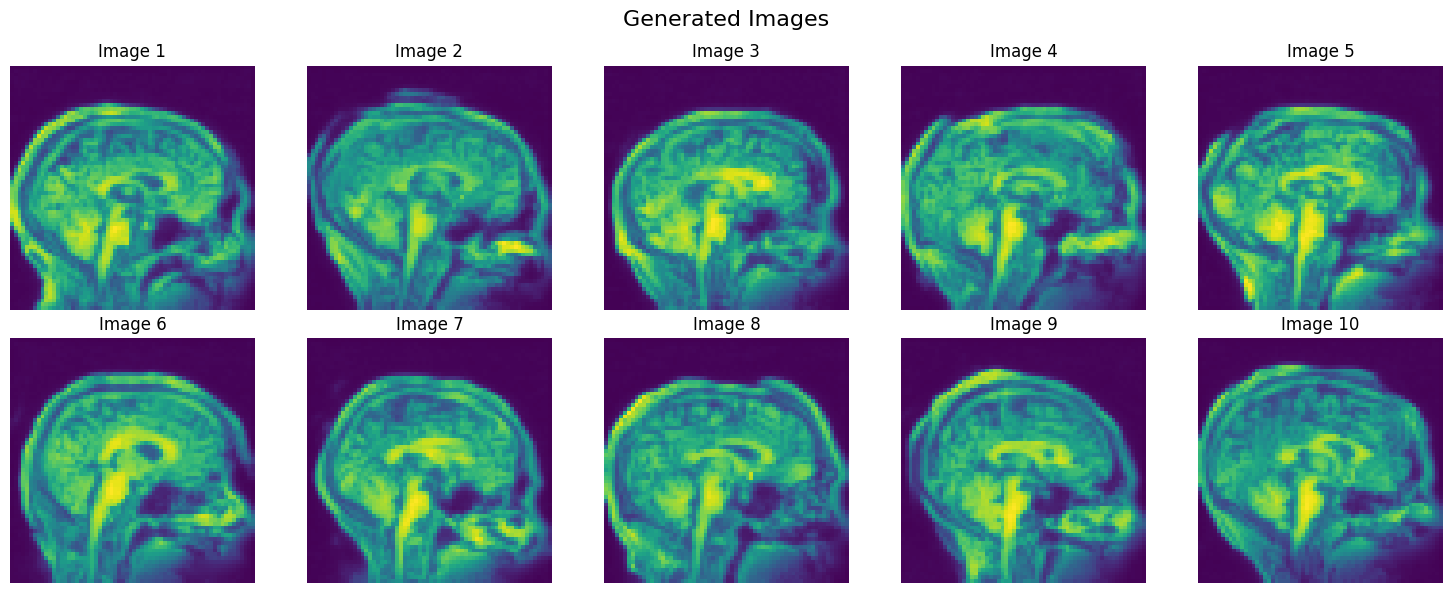

In [7]:
# Set the path to the generated data file
file_path = '/content/drive/My Drive/train_data_3000.pt'

# Load the generated data
train_data = torch.load(file_path)

# Move the data to the GPU and convert it to numpy
images = train_data[:10].cpu().numpy()

# Plot the first 10 images
plt.figure(figsize=(15, 6))  # Set the figure size
plt.suptitle("Generated Images", fontsize=16)  # Set the title

for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a subplot
    plt.imshow(images[i, 0])  # Display the image
    plt.axis('off')  # Turn off the axis
    plt.title(f"Image {i+1}")  # Set the individual title

plt.tight_layout()  # Adjust the layout
plt.show() # Display the plot

## Load and display corrupted images

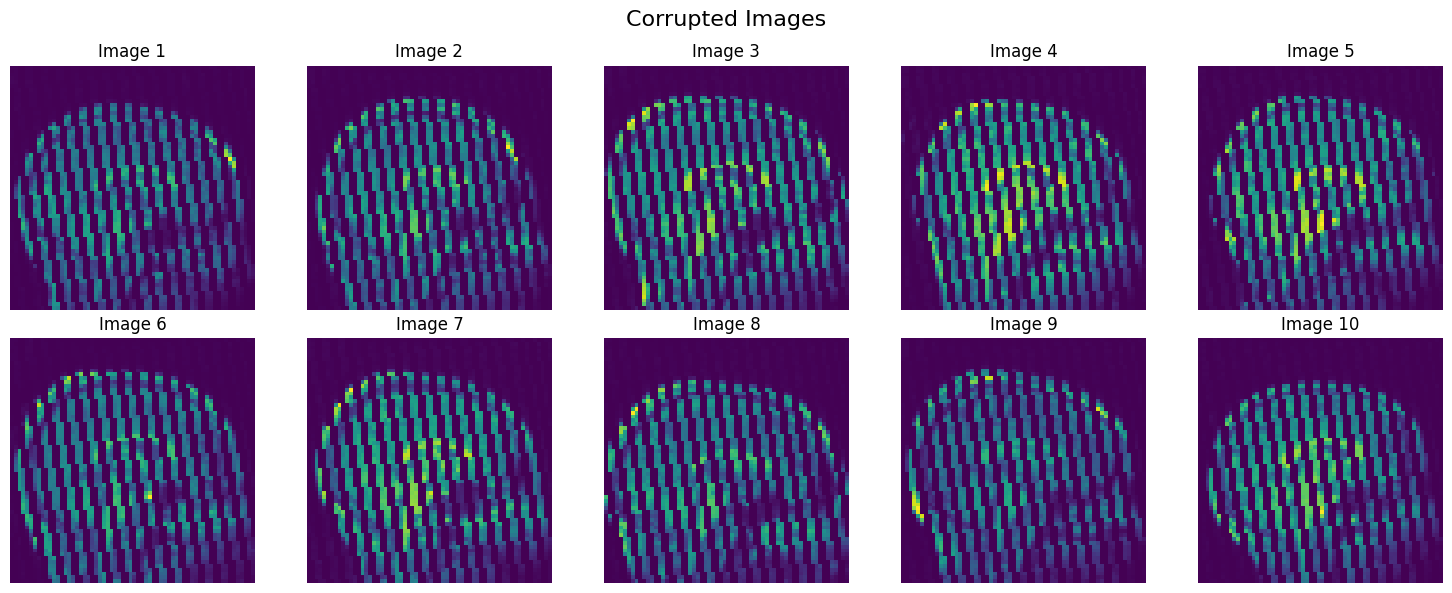

In [6]:
# Set the path to save the test data(This repository is also in the drive. Please change the path if you want to load it to your local machine)
file_path = '/content/drive/My Drive/test_set.npy'

# Load the test data
test_data = np.load(file_path)

# Get the first 10 images
test_images = test_data[:10]

# Display the first 10 images
plt.figure(figsize=(15, 6))  # Set the figure size
plt.suptitle("Corrupted Images", fontsize=16)  # Set the title

for i in range(10):
    plt.subplot(2, 5, i + 1)  # Create a subplot
    plt.imshow(test_images[i, 0])  # Display the image
    plt.axis('off')  # Turn off the axis
    plt.title(f"Image {i+1}")  # Set the individual title

plt.tight_layout()  # Adjust the layout
plt.show() # Display the plot

<br>

---

<br>

# **Question 2**  (25%)

Using the data generated in **Question 1**, create a PyTorch `TensorDataset` and a `DataLoader` for the training set.

Using the provided corrupted images inside `test_set.npy`, create another `TensorDataset` and a `DataLoader` for the test set.

The training dataset should provide batches of brain images generated in **Question 1** and should corrupt these images appropriately so that they resemble images in the test set. The dataset should also pair each image with its corresponding un-corrupted image as a label.

The test dataset should provide the corrupted images provided, for which no labels are available.

Display here ten images of your training dataset and ten images of your test dataset, and their corresponding labels when available.

<br>



## Corrupt these generated images

In this part, I should corrupt these generated images appropriately so that they resemble images in the test set. As shown in the corrupted image above, I found the mask pattern of the corrupted image to be relatively similar. And I call it a striped mask. In the corrupted image, the mask parts are all black and have a value of 0 in the pixel matrix, while the non-marked parts are all not black and do not have a value of 0 in the pixel matrix. So at first, I devised a mask to identify mask patterns in corrupted images.

In [ ]:

# Create the mask for the test data(0 is masked, 1 is unmasked)
mask = test_data > 0

# Calculate the average mask to count the probability distributions
average_mask = mask.mean(0).astype(np.float32)

# Display the average mask
np.set_printoptions(threshold=np.inf)
print(average_mask)


[[[1.   1.   0.   0.   1.   1.   0.   0.   1.   1.   0.   0.   1.   1.
   0.   0.   0.99 1.   0.   0.   0.98 0.99 0.   0.   0.99 1.   0.   0.
   0.97 0.99 0.   0.   0.99 0.99 0.   0.   1.   1.   0.   0.   0.98 0.99
   0.   0.   1.   0.99 0.   0.   1.   1.   0.   0.   1.   1.   0.   0.
   1.   0.   0.   1.   0.   0.   1.   1.  ]
  [1.   1.   0.   0.   1.   1.   0.   0.   1.   1.   0.   0.   1.   1.
   0.   0.   1.   1.   0.   0.   1.   1.   0.   0.   1.   1.   0.   0.
   1.   1.   0.   0.   1.   1.   0.   0.   1.   1.   0.   0.   1.   1.
   0.   0.   1.   1.   0.   0.   1.   1.   0.   0.   0.   1.   1.   0.
   0.   1.   0.   0.   1.   0.   0.   1.  ]
  [1.   1.   0.   0.   1.   1.   0.   0.   1.   1.   0.   0.   1.   1.
   0.   0.   1.   1.   0.   0.   1.   1.   0.   0.   1.   1.   0.   0.
   1.   1.   0.   0.   1.   1.   0.   0.   1.   1.   0.   0.   0.   1.
   1.   0.   0.   1.   1.   0.   0.   1.   1.   0.   0.   1.   1.   0.
   0.   1.   0.   0.   1.   0.   0.   1.  ]
  [1.   1.   0

By looking at the matrix of averaged mask, I found that 100 corrupted images have approximately the same stripe mask pattern. In this way I generalised the stripe masking pattern and then corrupted the image and used mask multiplication to corrupt the train dataset.

In [ ]:
# Set the threshold for the mask to create a general mask
threshold = 0.5
general_mask = average_mask > threshold

# Apply the general mask to the training data to create the corrupted data
train_damaged_data = train_data.cpu() * general_mask

## Create a PyTorch `TensorDataset` and a `DataLoader` for the training set and test set.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
##I didn't put the pixel value of the image between -1 and 1 here, I'll explain why later.

# Create the training dataset using the TensorDataset
train_dataset = TensorDataset(train_damaged_data, train_data)  # The training dataset contains the corrupted data and the uncorrupted data

# Create DataLoader
batch_size = 40 # batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the test dataset using the TensorDataset
test_data = torch.tensor(test_data, dtype=torch.float32)
test_dataset = TensorDataset(test_data)  # The test dataset contains the corrupted data

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-66-b4c4e1eecf5b>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = torch.tensor(test_data, dtype=torch.float32)


## Display the train dataset

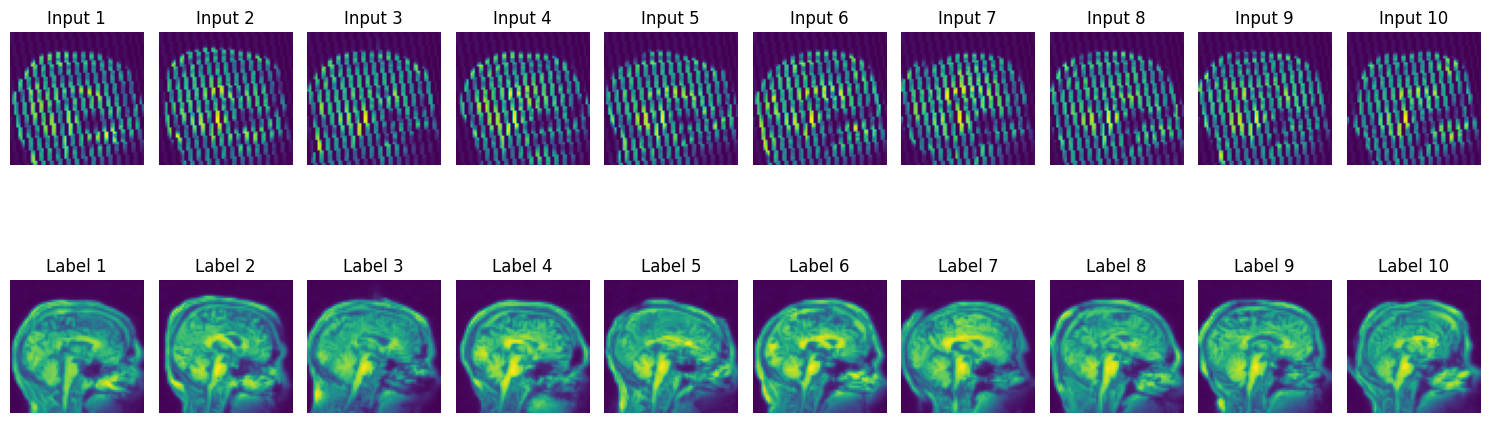

In [ ]:
# Select the first batch from the training loader
train_batch = next(iter(train_loader))
train_inputs, train_labels = train_batch  # (corrupted data, uncorrupted data)

# Plot the first 10 images from the batch
plt.figure(figsize=(15, 6)) # Set the figure size

# Display the first 10 images
for i in range(10):

    # Display the corrupted image
    plt.subplot(2, 10, i + 1)
    plt.imshow(train_inputs[i].squeeze().cpu().numpy())
    plt.axis("off")
    plt.title(f"Input {i+1}")

    # Display the corresponding uncorrupted image
    plt.subplot(2, 10, i + 11)
    plt.imshow(train_labels[i].squeeze().cpu().numpy())
    plt.axis("off")
    plt.title(f"Label {i+1}")

plt.tight_layout()# Adjust the layout
plt.show()# Display the plot

## Display the test dataset

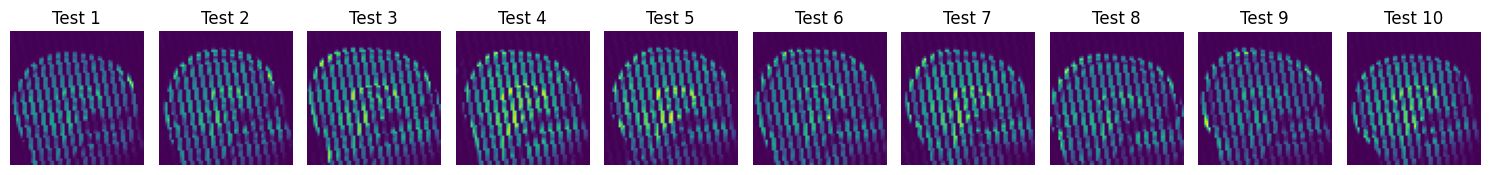

In [ ]:
# Select the first batch from the test loader
test_batch = next(iter(test_loader))
test_inputs = test_batch[0]

# Plot the first 10 images from the batch
plt.figure(figsize=(15, 6))

# Display the first 10 images
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(test_inputs[i].squeeze().cpu().numpy())
    plt.axis("off")
    plt.title(f"Test {i+1}")

plt.tight_layout() # Adjust the layout
plt.show() # Display the plot

<br>

---

<br>

# **Question 3** (50%)

Using the dataset created in **Question 2**, design and train an architecture to recover the missing image lines of the provided test dataset.

Once you have trained your architecture, display here ten images of the test set with the recovered lines filled in.

Additionally, save the test data with the missing values filled in into a numpy file called `test_set_nogaps.npy`. These images should be **in the same order** as those in the `test_set.npy` file and should have the same pixel size of 64x64. **Any images not contained in the `test_set_nogaps.npy` file or incorrectly ordered will not be marked.**

You have freedom to choose an architecture that you consider appropriate to solve this problem. However, you will need to train your chosen architecture as part of the assessment: **pre-trained networks are not allowed**.

You will be assessed by the quality of your predictions of the missing data values and additional marks will be given for originality in your network design choices. You should include, as part of your answer, a paragraph explaining the architecture you have chosen and any additional design choices and hyperparameters that have been important to build your solution.

This is an open-book assessment and you are encouraged to use resources online, including  tools like chatGPT. However, make sure to always mention the sources for your code and ideas, including websites, papers, and tools like chatGPT.

<br>


In [ ]:
!pip install torchmetrics
!pip install livelossplot

In [ ]:
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
import torchvision
from torchvision import transforms
from torchmetrics import StructuralSimilarityIndexMeasure as SSIM
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from livelossplot import PlotLosses

In this part, since the task is to remove the striped masking pattern of corrupted image and restore it to uncorrupted image, so I would classify this as a stationary and fixed noise cancellation task. Therefore compared to complex generative models such as VAE and Gans, I chose the Unet network as my model. My architecture is the Unet combined with multi-head self-attention mechanism.

## Network construction

In [ ]:
## Multi-Head Self-Attention Module
class MultiHeadSelfAttention(nn.Module):

    def __init__(self, in_c, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        assert in_c % num_heads == 0, # in_c must be divisible by num_heads
        self.num_heads = num_heads # number of heads
        self.head_dim = in_c // num_heads  # dimension of each head

        # Define the Query, Key, and Value linear transformations
        self.query = nn.Conv2d(in_c, in_c, kernel_size=1)
        self.key = nn.Conv2d(in_c, in_c, kernel_size=1)
        self.value = nn.Conv2d(in_c, in_c, kernel_size=1)

        # Define the gamma parameter for the residual connection
        self.gamma = nn.Parameter(torch.zeros(1))

    # Forward pass
    def forward(self, x):
        batch_size, channels, height, width = x.size() # get the input size
        head_dim = self.head_dim # Set the head dimension
        num_heads = self.num_heads # Set the number of heads

        # Generate the Query, Key, and Value
        query = self.query(x).view(batch_size, num_heads, head_dim, height * width)  # B, H, C/H, HW
        key = self.key(x).view(batch_size, num_heads, head_dim, height * width)      # B, H, C/H, HW
        value = self.value(x).view(batch_size, num_heads, head_dim, height * width)  # B, H, C/H, HW

        # Calculate the attention
        attention = torch.einsum('bhcw,bhdw->bhcd', query, key)  # B, H, HW, HW
        attention = F.softmax(attention / (head_dim ** 0.5), dim=-1)

        # Apply the attention to the value
        out = torch.einsum('bhcd,bhdw->bhcw', attention, value)  # B, H, C/H, HW
        out = out.view(batch_size, channels, height, width)  # 恢复到原始分辨率

        # Apply the gamma parameter to the residual connection
        out = self.gamma * out + x
        return out

In [ ]:
## Define a convolutional block of the UNet
class ConvBlock(nn.Module):

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1) # 3x3 convolution
        self.attention = MultiHeadSelfAttention(out_c)  # multi-head self-attention
        self.gn = nn.GroupNorm(8, out_c) # group normalisation
        self.act = nn.SiLU() # SiLU activation function

    def forward(self, x):
        x = self.conv(x) # convolution
        x = self.attention(x) # multi-head self-attention
        x = self.gn(x) # group normalisation
        x = self.act(x) # activation function
        return x

# Define an encoder block of the U-Net with time-embedding
class EncBlock(nn.Module):

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.conv_block1 = ConvBlock(in_c, out_c, embed_dim) # convolutional block 1
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim) # convolutional block 2
        self.res = nn.Conv2d(in_c, out_c, 1) # add a convolutional layer
        self.pool = nn.MaxPool2d((2, 2)) # max pooling

    def forward(self, x):
        h = self.conv_block1(x) # convolutional block 1
        h = self.conv_block2(h) # convolutional block 2
        h += self.res(x) # residual block skip connection
        p = self.pool(h) # max pooling
        return h, p

# Define an decoder block of the U-Net
class DecBlock(nn.Module):

    def __init__(self, in_c, out_c, embed_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0) # up-sampling
        self.conv_block1 = ConvBlock(in_c + out_c, out_c, embed_dim)  # convolutional block 1
        self.conv_block2 = ConvBlock(out_c, out_c, embed_dim) # convolutional block 2

    def forward(self, x, s):
        x = self.up(x)  # up-sampling
        h = torch.cat([x, s], axis=1)  # concatenate the skip connection
        h = self.conv_block1(h) # convolutional block 1
        h = self.conv_block2(h) # convolutional block 2
        return h + x  # skip connection

In [ ]:
# Define the U-Net model
class Unet(nn.Module):

    def __init__(self, n_channels, embed_dim,dropout=0.1):
        super().__init__()

        # Embedding layer
        self.embed = nn.Sequential(nn.Linear(embed_dim, embed_dim),
                                   nn.GELU(),# GELU activation function
                                   nn.Linear(embed_dim, embed_dim))

        # encoder blocks(5 encoder blocks)
        self.e1 = EncBlock(n_channels, 64, embed_dim)
        self.e2 = EncBlock(64, 128, embed_dim)
        self.e3 = EncBlock(128, 256, embed_dim)
        self.e4 = EncBlock(256, 512, embed_dim)
        self.e5 = EncBlock(512, 1024, embed_dim)

        # bottleneck(3 bottleneck)
        self.b1 = ConvBlock(1024, 2048, embed_dim)
        self.b2 = ConvBlock(2048, 2048, embed_dim)
        self.b3 = ConvBlock(2048, 1024, embed_dim)

        # decoder blocks(5 decoder blocks)
        self.d1 = DecBlock(1024, 512, embed_dim)
        self.d2 = DecBlock(512, 256, embed_dim)
        self.d3 = DecBlock(256, 128, embed_dim)
        self.d4 = DecBlock(128, 64,embed_dim)
        self.d5 = DecBlock(64, 64, embed_dim)

        # output layer
        self.output = nn.Sequential(
            nn.Conv2d(64, n_channels, kernel_size=1, padding=0),
            nn.Sigmoid()  # Sigmoid activation function
        )

    def forward(self, x):

        # encoder
        s1, x = self.e1(x)
        s2, x = self.e2(x)
        s3, x = self.e3(x)
        s4, x = self.e4(x)
        s5, x = self.e5(x)

        # bottleneck
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)

        # decoder
        x = self.d1(x, s5)
        x = self.d2(x, s4)
        x = self.d3(x, s3)
        x = self.d4(x, s2)
        x = self.d5(x, s1)

        # output
        output = self.output(x)

        return output

## Model training

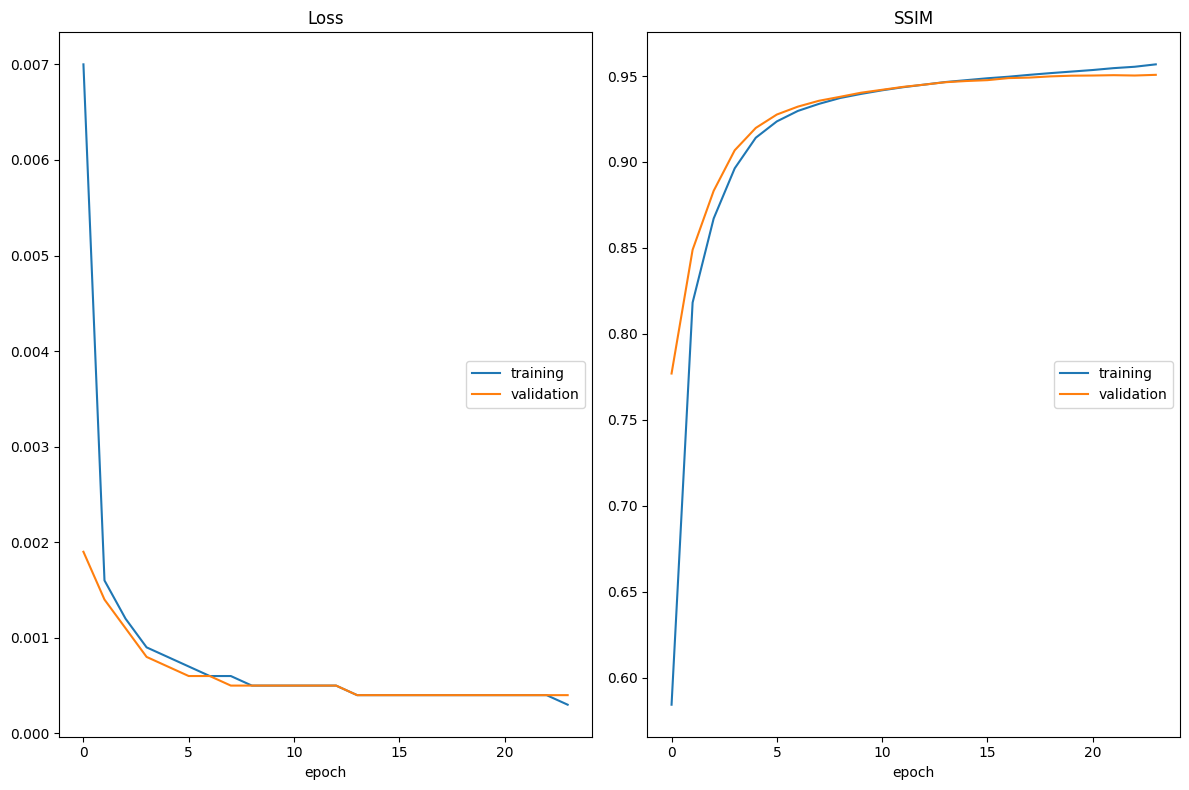

Loss
	training         	 (min:    0.000, max:    0.007, cur:    0.000)
	validation       	 (min:    0.000, max:    0.002, cur:    0.000)
SSIM
	training         	 (min:    0.584, max:    0.957, cur:    0.957)
	validation       	 (min:    0.777, max:    0.951, cur:    0.951)
Epoch 24/24, Train Loss: 0.0003, Val Loss: 0.0004, Train SSIM: 0.9568, Val SSIM: 0.9507


In [ ]:
# Set the random seed for reproducibility
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the random seed
set_random_seed(42)

device='cuda'# Use the GPU
n_channels=1 # number of channels
x_dim = 64 # dimension of the image

# Set the hyperparameters
epochs = 24 # number of epochs
learning_rate = 1e-4 # learning rate


# Divide the training dataset into training and validation subsets(80% training, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create the DataLoader
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id))
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False,worker_init_fn=lambda worker_id: np.random.seed(42 + worker_id))

# Initialize the model
model = Unet(n_channels,x_dim*4).to(device)

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Set the learning rate scheduler(I tried both none, StepLR and ReduceLROnPlateau, and found that ReduceLROnPlateau is more effective)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=8, verbose=True)

# Set the loss function and the SSIM metric
criterion = F.mse_loss

# The SSIM metric is used to evaluate the model
ssim_metric = SSIM(data_range=1.0).to(device)

# Initialize the live plot
liveloss = PlotLosses()

# Train the model
for epoch in range(epochs):
    logs = {}

    model.train()# Set the model to training mode

    train_loss = 0
    train_ssim = 0

    for batch in train_loader:

        noisy_images, clean_images = batch
        noisy_images, clean_images = noisy_images.to(device).float(), clean_images.to(device).float()# Get the noisy and clean images

        # Predict the clean images
        optimizer.zero_grad()
        predicted_clean = model(noisy_images)

        loss = criterion(predicted_clean.float(), clean_images.float())# Calculate the loss
        loss.backward()# Backward pass
        optimizer.step()# Update the weights


        train_loss += loss.item()# Calculate the loss

        ssim_score = ssim_metric(predicted_clean, clean_images) # Calculate the SSIM score
        train_ssim += ssim_score.item()

    logs['' + 'Loss'] = round(train_loss / len(train_loader),4)
    logs['' + 'SSIM'] = round(train_ssim/ len(train_loader),4)

    model.eval()# Set the model to evaluation mode

    val_loss = 0
    val_ssim = 0

    with torch.no_grad():
        for batch in val_loader:
            noisy_images, clean_images = batch
            noisy_images, clean_images = noisy_images.to(device).float(), clean_images.to(device).float()# Get the noisy and clean images

            # Predict the clean images
            predicted_clean = model(noisy_images)

            # Calculate the loss
            loss = criterion(predicted_clean, clean_images)
            val_loss += loss.item()

            # Calculate the SSIM score
            ssim_score = ssim_metric(predicted_clean, clean_images)
            val_ssim += ssim_score.item()

    logs['val_' + 'Loss'] = round(val_loss / len(val_loader),4)
    logs['val_' + 'SSIM'] = round(val_ssim/ len(val_loader),4)

    # Update the live plot
    liveloss.update(logs)
    liveloss.draw()

    # Print the epoch, training loss, validation loss, training SSIM, and validation SSIM
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, "
          f"Val Loss: {val_loss / len(val_loader):.4f}, Train SSIM: {train_ssim / len(train_loader):.4f}, Val SSIM: {val_ssim / len(val_loader):.4f}")

     # Update the learning rate
    scheduler.step(val_loss / len(val_loader))  # ReduceLROnPlateau





I found that the training and validation sets can balance to optimality when epoch is 24. So I save when the epoch is 24 as my best_model.

In [ ]:
save_path = '/content/drive/My Drive/'  # Set the path to save the model
torch.save(model, os.path.join(save_path, f"best_model.pth")) # Save the model

## Model prediction

In [ ]:
predictions = []  # save the predictions

with torch.no_grad():
    for batch in test_loader:
        noisy_images = batch[0].to(device).float()  # Get the noisy images

        predicted_clean = model(noisy_images)  # Predict the clean images by the model

        predictions.append(predicted_clean.cpu()) # Append the predictions

# Concatenate the predictions
predictions_tensor = torch.cat(predictions, dim=0)

## Display the result

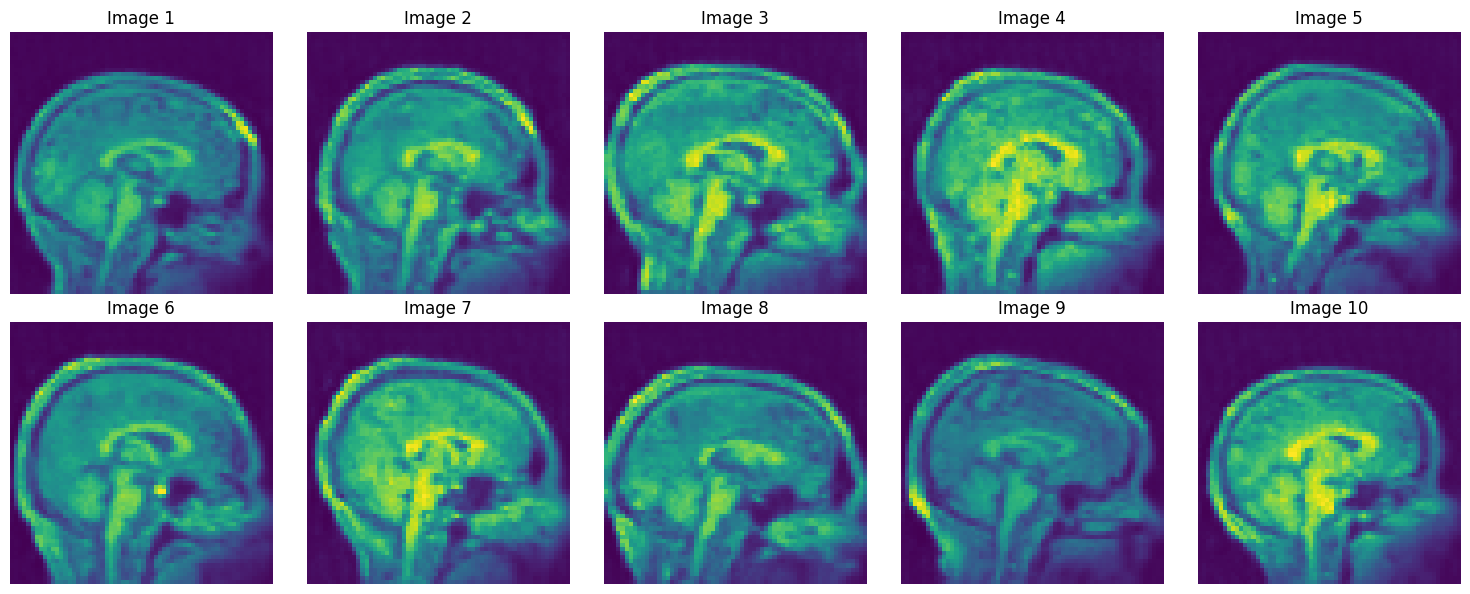

In [ ]:
# Plot the first 10 images

plt.figure(figsize=(15, 6))  # set the figure size

for i in range(10):
    plt.subplot(2, 5, i + 1)  # create a subplot
    plt.imshow(predictions_tensor[i,0])  # display the image
    plt.axis('off')  # turn off the axis
    plt.title(f"Image {i+1}")  # set the individual title

plt.tight_layout()  # adjust the layout
plt.show()

In [ ]:
## Save the predictions to a file
out_path = '/content/drive/My Drive/test_set_nogaps.npy' # Set the path to save the predictions
np.save(out_path, predictions_tensor.numpy()) # Save the predictions to a file

My model is the UNet combined with a multi-attention mechanism.

Firstly, the construction of model, here I have used the multi-head attention mechanism to both better parse the local features of the image and to speed up the runtime. In addition I used 5 decoding and encoding layers to increase the complexity of the model. Of course in UNet I used a combination of Sigomid and GELU activation functions, the former in the output layer and the latter in the hidden layer, which is superior to the way I tried the combination of Tanh and SiLu. Since I did not use Tanh, I also did not expand the image between -1 and 1.

The second is the training of the model, I tried three gradient descent algorithms, Adam, Adamw and SGD, and finally found that Adam has the best performance. batch_size I chose 40. at the same time, in order to better reduce the loss of the validation set, I used ReduceLROnPlateau to dynamically update the learning rate, and achieved better results.

The third is the epoch selection of the model, as shown in the figure in the experiment, I selected two metrics, which are Loss and SSIM values. I started to set the epoch at 50, but found that the model overfitted when the epoch was greater than 30. Therefore, I found that when epoch is equal to 24, the model achieves a relative optimum for the results on the training and validation sets. In the end, I saved the model trained after the 24th epoch, and this is my final model.

Finally, I fed test_data into the final model to get the results and saved them. If time permits, my next step should be to put the validation set back into the training set and retrain a final model, as this maximises the use of the available dataset. This will be my future work.


<br>

---

<br>